In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import random

from src.frechetdist import frdist
from src.find_transform import *
from src.utils import *
from src.shape_align import *
from src.shape_utils import *
from src.find_transform import find_best_transform_ransac, aligned_coords2line
from src.curvature import edge_coords2curvatures

from typing import List, Dict, Tuple
from joblib import Parallel, delayed
from skimage.color import rgb2lab, lab2rgb
from tqdm import tqdm


In [4]:
data_dir = '/mnt/c/Users/dev/Documents/fresco/dataset'
palette = np.array([[4.83058360e+01, -4.28336049e+00, -1.04226657e+00],
                    [7.28763389e+01,  1.10190913e+01,  2.91083397e+01],
                    [1.93975643e+01,  8.21757008e+00, -6.52862709e+00],
                    [6.12470461e+01,  6.38868771e+00,  1.05191202e+01],
                    [8.70237508e+01,  2.60029629e+00,  6.34060233e+00],
                    [3.84328672e+01,  2.22768163e+01,  1.17465682e+00],
                    [3.29131583e+01,  3.06846260e-02, -6.19825618e+00]])

In [15]:
frags = [
    pad_fragment_to_size(build_fragment_from_directory(data_dir + '/9'), 200),
    pad_fragment_to_size(build_fragment_from_directory(data_dir + '/11'), 200),
#     build_fragment(14, None), 
#     build_fragment(15, None),
#     build_fragment(10, None),
]

frag1 = frags[0]
frag2 = frags[1]

In [16]:
frag3 = rotate_fragment(pad_fragment_to_size(frag1, 200), 60)

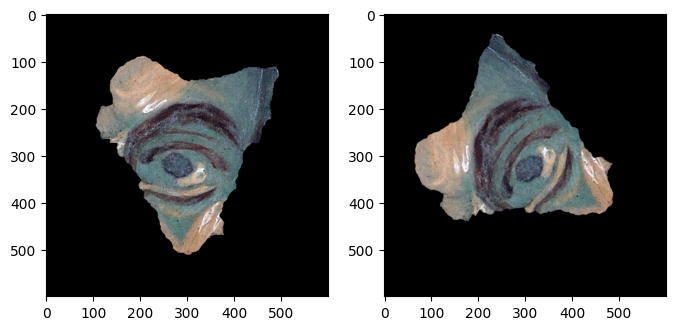

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
axes[0].imshow(frag1.fragment)
axes[1].imshow(frag3.fragment)

## Longest common subedge

In [18]:
frags = [frag1, frag2]
descriptors, alignment = pairwise_alignment(palette, frags)

Computing shape descriptors...
Computing pairwise alignments...
Aligning fragments 0 and 1:
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:10<00:00, 234.66it/s]


In [19]:
l, r = 0, 1

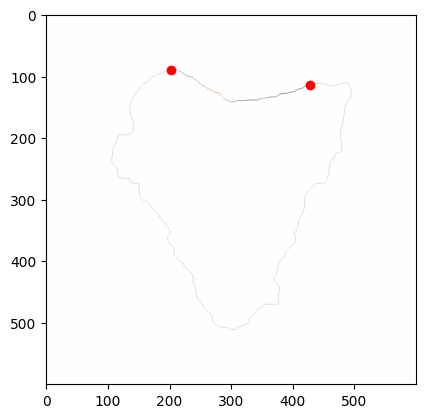

In [20]:
common_edge = np.ones(frags[l].fragment.shape)
color_edge, edge_coords, curvs = descriptors[l].color_edge, descriptors[l].edge_coords, descriptors[l].curvatures
indices = alignment[(l, r)]
i_indices = [i for (i, j) in indices]
for i, point in enumerate(edge_coords):
    common_edge[point[0], point[1]] = 0.8
common_edge = rgb2lab(common_edge)
    
line1 = []
colors = []
for (i, j) in indices:
    color = color_edge[i - 1]
    y, x = edge_coords[i - 1]
    line1.append((y, x))
    colors.append(color)
    
    
for c, (y, x) in zip(colors, line1):
    common_edge[y, x] = c
#     common_edge[y, x] = color

plt.imshow(lab2rgb(common_edge))
common_edge = lab2rgb(common_edge)
y1, x1 = edge_coords[indices[0][0] - 1]
y2, x2 = edge_coords[indices[-1][0] - 1]
plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

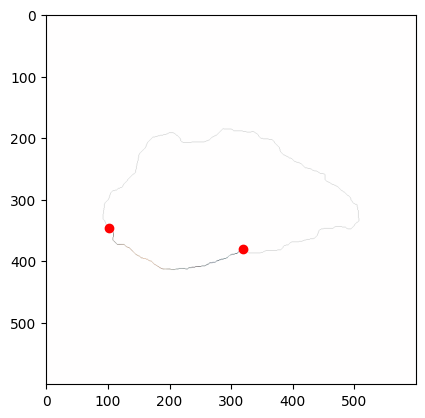

In [22]:
common_edge = np.ones(frags[r].fragment.shape)
color_edge, edge_coords, curvs = descriptors[r].color_edge[::-1], descriptors[r].edge_coords[::-1], descriptors[r].curvatures[::-1]
indices = alignment[(l, r)]
i_indices = [j for (i, j) in indices]
for i, point in enumerate(edge_coords):
    common_edge[point[0], point[1]] = 0.8
common_edge = rgb2lab(common_edge)
    
line2 = []
colors = []
for (i, j) in indices:
    color = color_edge[j - 1]
    y, x = edge_coords[j - 1]
    line2.append((y, x))
    colors.append(color)
    
for c, (y, x) in zip(colors, line2):
    common_edge[y, x] = c
#     common_edge[y, x] = color

plt.imshow(lab2rgb(common_edge))
common_edge = lab2rgb(common_edge)
y1, x1 = edge_coords[indices[0][1] - 1]
y2, x2 = edge_coords[indices[-1][1] - 1]
plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

## Aligning fragments according to common subedge

In [46]:
line1 = aligned_coords2line(alignment[(l, r)], descriptors[l].edge_coords, left=True)
line2 = aligned_coords2line(alignment[(l, r)], descriptors[r].edge_coords[::-1], left=False)

In [47]:
line1 -= frags[l].fragment.shape[0] // 2
line2 -= frags[r].fragment.shape[0] // 2

In [48]:
# transform_params = estimate_transform_params(line1[0], line1[-1], line2[0], line2[-1])
# transformed_line1 = transform_line(line1, transform_params).astype(int)

In [49]:
best_transform_params = find_best_transform_ransac(line1, line2)
transformed_line1 = transform_line(line1, best_transform_params).astype(int)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


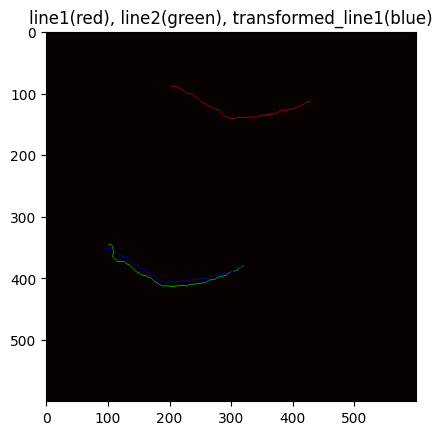

In [50]:
common_edge = np.ones(frags[l].fragment.shape)
indices = alignment[(l, r)]
common_edge = lab2rgb(common_edge)
line1 += frags[l].fragment.shape[0] // 2
line2 += frags[l].fragment.shape[0] // 2
transformed_line1 += frags[l].fragment.shape[0] // 2
for (y, x) in line1:
    if y < 0 or y >= common_edge.shape[0] or x < 0 or x >= common_edge.shape[1]:
        continue
    common_edge[y, x] = [200, 0, 0]
for (y, x) in line2:
    if y < 0 or y >= common_edge.shape[0] or x < 0 or x >= common_edge.shape[1]:
        continue
    common_edge[y, x] = [0, 200, 0]
for (y, x) in transformed_line1:
    if y < 0 or y >= common_edge.shape[0] or x < 0 or x >= common_edge.shape[1]:
        continue
    common_edge[y, x] = [0, 0, 200]
# y1, x1 = edge_coords[indices[0][0] - 1]
# y2, x2 = edge_coords[indices[-1][0] - 1]
# plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)
plt.title("line1(red), line2(green), transformed_line1(blue)")
plt.show()

## Speed comparison of different distance measurement methods

In [32]:
import time

In [51]:
# from .geometry import euclidean_distance
def euclidean_distance(point1, point2):
    '''
    Args:
    point1: type array two values [x, y]
    point2: type array two values [x, y]
    Returns:
    Distance of two points
    Descriptions:
    Calculate Euclidian distance of two points in Euclidian space
    '''
    
    return np.round(np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2), 2)

'''
Discrete Frechet distance between 2 curves
based on http://www.kr.tuwien.ac.at/staff/eiter/et-archive/cdtr9464.pdf
modified to be iterative and have better memory usage
'''

def frechet_distance(curve1, curve2):
    '''
    Args:
    polyP: polynomial representing curve 1
    polyQ: polynomial representing curve 2
    Returns:
    Frechet distance between two curves
    Descriptions:
    Calculate Frechet distance between two curves
    '''
  
    longcalcurve = curve1 if len(curve1) >= len(curve2) else curve2
    shortcalcurve = curve2 if len(curve1) >= len(curve2) else curve1
    
    prev_resultscalcol = []
    for i in range(0, len(longcalcurve)):
        current_resultscalcol = []
        for j in range(0, len(shortcalcurve)):
            current_resultscalcol.append(
                calc_value(
                    i, j, prev_resultscalcol, 
                    current_resultscalcol, 
                    longcalcurve, shortcalcurve
                )
            )
        prev_resultscalcol = current_resultscalcol
    return prev_resultscalcol[len(shortcalcurve) - 1]

def calc_value(i, j, prevResultsCol, currentResultsCol, longCurve, shortCurve):
    if i == 0 and j == 0:
        return euclidean_distance(longCurve[0], shortCurve[0])
    if i > 0 and j == 0:
        return max(prevResultsCol[0], euclidean_distance(longCurve[i], shortCurve[0]))
    last_result = currentResultsCol[len(currentResultsCol) - 1]
    if i == 0 and j > 0:
        return max(last_result, euclidean_distance(longCurve[0], shortCurve[j]))
    return max(
        min(prevResultsCol[j], prevResultsCol[j - 1], last_result),
        euclidean_distance(longCurve[i], shortCurve[j])
    )

In [52]:
start_time = time.time()
print(frdist(transformed_line1, line2))
print("Time: ", time.time() - start_time)

10.0
Time:  0.6487152576446533


In [53]:
start_time = time.time()
print(frechet_distance(transformed_line1, line2))
print("Time: ", time.time() - start_time)

10.0
Time:  1.4012961387634277


In [54]:
start_time = time.time()
max_dist = 0
dists = [euclidean_distance(transformed_line1[i], line2[i]) for i in range(len(transformed_line1))]
print(max(dists))
print("Time: ", time.time() - start_time)

11.18
Time:  0.008434057235717773


## Visualizing the best transform

In [59]:
from src.find_transform import *

In [62]:

best_transform_params = find_best_transform_ransac(line1, line2)

In [68]:
padded_frag2 = pad_fragment_to_size(frag2, 300)
padded_frag2.fragment = padded_frag2.fragment / 255

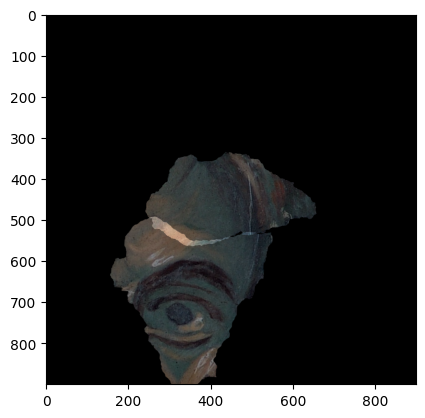

In [69]:
blended = blend_fragments(
    padded_frag2,
    transform_fragment(
        pad_fragment_to_size(frag1, 300),
        best_transform_params
    )
)
plt.imshow(blended.fragment)